In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

This notebook reads the data in pdiot_data/2021, removes recordings that are too small, and creates sliding windows of the recordings. These are then saved into ../data/sliding_windows_sizeX_stepX

## Getting the data

In [90]:
data_path = '../pdiot-data/2021/'
sensor='Thingy'

In [91]:
def get_base_df(sensor):
    base_df = pd.DataFrame()

    # Get a list of all respeck files in all the student folders
    all_files = []
    for f in os.listdir(data_path):
        if os.path.isdir(data_path + '/' + f):
            files = os.listdir(data_path + '/' + f)
            files = [data_path + '/' + f + '/' + f2 for f2 in files if sensor in f2]
            all_files += files
    
    # Load them all into a df
    for filename in all_files:
        #full_path = f"{clean_data_folder}/{filename}"
        #print(full_path)

        # load data into a DataFrame
        new_df = pd.read_csv(filename)

        # merge into the base DataFrame
        base_df = pd.concat([base_df, new_df])
        
    return base_df

base_df = get_base_df(sensor)

In [4]:
# We want to remove any falling recordings over 700 datapoints as this suggests that it contains falling + getting up
# We also want to remove any recordings less than the window size

In [92]:
smallest_window_size = 25
s = base_df.groupby('recording_id').size() >= smallest_window_size

filtered_df = base_df[base_df['recording_id'].isin(s.keys()[s])]

# One Thingy recording has a bunch of NAN
filtered_df = filtered_df[filtered_df['recording_id'] != 'Thingy_s1817455_Falling on the left_29-09-2021_16-13-56']

# Remove falling recordings longer than 700
s = filtered_df[filtered_df['activity_type'].str.contains('Falling')].groupby('recording_id').size() >= 700

filtered_df = filtered_df[~filtered_df['recording_id'].isin(s.keys()[s])]

# s1702583 has really inconsistent activity naming - remove
filtered_df = filtered_df[filtered_df['subject_id'] != 's1702583']

In [93]:
# Check that other people named correctly
filtered_df[filtered_df.apply(lambda x: not(x.activity_type in x.recording_id or x.activity_type.replace(' ', '_') in x.recording_id), axis=1)]

,timestamp,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z,mag_x,mag_y,mag_z,sensor_type,activity_type,activity_code,subject_id,notes,recording_id,Unnamed: 0


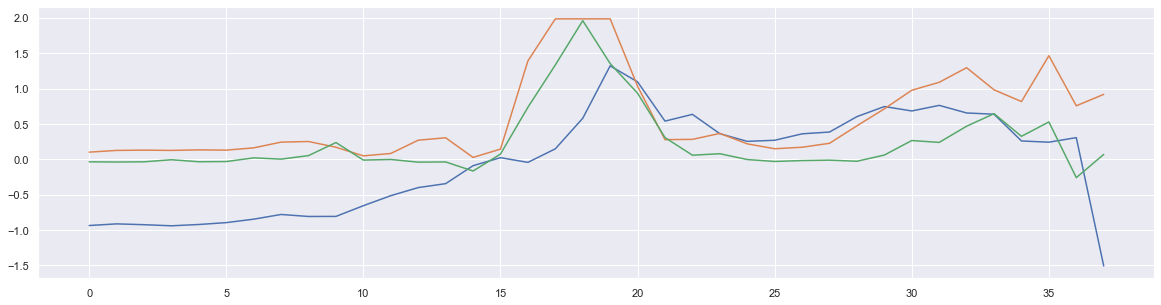

In [95]:
def plot_by_id(i): 
    plot_recording = base_df[base_df['recording_id'] == i]
    plot_recording = plot_recording.reset_index()
    plt.plot(plot_recording.index, plot_recording['accel_x'])
    plt.plot(plot_recording.index, plot_recording['accel_y'])
    plt.plot(plot_recording.index, plot_recording['accel_z'])
    
plot_by_id('Thingy_s1817455_Falling on the left_29-09-2021_16-13-56')

C:\Users\Gwenyth\miniconda3\envs\pdiot\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


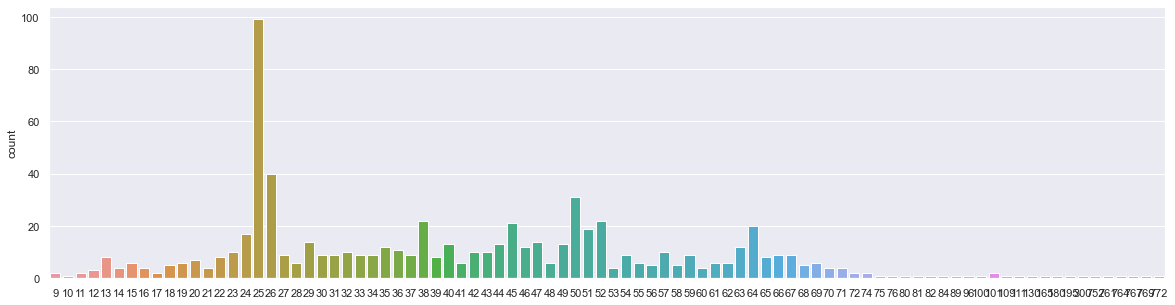

In [96]:
#base_df[base_df['activity_type'] == "Falling on the back"].groupby('recording_id').size().sort_values().head(40)
#base_df.groupby('recording_id').size().sort_values().head(100)
from collections import Counter
#Counter(base_df[base_df['activity_type'] == "Falling on the back"].groupby('recording_id').size().sort_values())
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(20,5)})
ax = sns.countplot(base_df[base_df['activity_type'] == "Falling on knees"].groupby('recording_id').size().sort_values())

In [98]:
filtered_df.groupby('activity_type').size().sort_values()

activity_type
Falling on knees           28227
Falling on the right       28339
Falling on the left        28780
Falling on the back        28802
Running                    33928
Walking at normal speed    33967
Lying down on back         34758
Lying down right           34768
Sitting bent forward       34769
Movement                   34797
Sitting                    34799
Lying down left            34800
Standing                   34802
Lying down on stomach      34814
Descending stairs          34825
Sitting bent backward      34827
Desk work                  34849
Climbing stairs            34913
dtype: int64

## Preparing the sliding windows

In [22]:
filtered_df['activity_type'].unique()

array(['Climbing stairs', 'Descending stairs', 'Desk work',
       'Falling on knees', 'Falling on the back', 'Falling on the left',
       'Falling on the right', 'Lying down left', 'Lying down on back',
       'Lying down on stomach', 'Lying down right', 'Movement', 'Running',
       'Sitting bent backward', 'Sitting bent forward', 'Sitting',
       'Standing', 'Walking at normal speed'], dtype=object)

In [23]:
#activities_of_interest = ['Standing', 'Walking at normal speed']
activities_of_interest = filtered_df['activity_type'].unique()

In [99]:
window_size = smallest_window_size 
step_size = smallest_window_size

window_number = 0 # start a counter at 0 to keep track of the window number

all_overlapping_windows = []

for rid, group in filtered_df.groupby("recording_id"):
    if group['activity_type'].iloc[0] in activities_of_interest:
    
        print(f"Processing rid = {rid}")

        large_enough_windows = [window for window in group.rolling(window=window_size, min_periods=window_size) if len(window) == window_size]

        overlapping_windows = large_enough_windows[::step_size] 

        # then we will append a window ID to each window
        for window in overlapping_windows:
            window.loc[:, 'window_id'] = window_number
            window_number += 1

        #print(overlapping_windows)

        all_overlapping_windows.append(pd.concat(overlapping_windows).reset_index(drop=True))

Processing rid = Thingy_s1541031_Climbing stairs_06-10-2021_11-27-07
Processing rid = Thingy_s1541031_Descending stairs_06-10-2021_11-26-27
Processing rid = Thingy_s1541031_Desk work_06-10-2021_11-09-15


C:\Users\Gwenyth\miniconda3\envs\pdiot\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Gwenyth\miniconda3\envs\pdiot\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


Processing rid = Thingy_s1541031_Falling on knees_06-10-2021_16-22-46
Processing rid = Thingy_s1541031_Falling on knees_06-10-2021_16-22-51
Processing rid = Thingy_s1541031_Falling on knees_06-10-2021_16-22-56
Processing rid = Thingy_s1541031_Falling on knees_06-10-2021_16-23-02
Processing rid = Thingy_s1541031_Falling on knees_06-10-2021_16-23-08
Processing rid = Thingy_s1541031_Falling on knees_06-10-2021_16-23-14
Processing rid = Thingy_s1541031_Falling on knees_06-10-2021_16-23-21
Processing rid = Thingy_s1541031_Falling on knees_06-10-2021_16-23-29
Processing rid = Thingy_s1541031_Falling on knees_06-10-2021_16-23-35
Processing rid = Thingy_s1541031_Falling on knees_06-10-2021_16-23-41
Processing rid = Thingy_s1541031_Falling on knees_06-10-2021_16-23-48
Processing rid = Thingy_s1541031_Falling on knees_06-10-2021_16-23-54
Processing rid = Thingy_s1541031_Falling on knees_06-10-2021_16-24-00
Processing rid = Thingy_s1541031_Falling on knees_06-10-2021_16-24-07
Processing rid = Thi

Processing rid = Thingy_s1704145_Lying down on back_23-09-2021_10-53-38
Processing rid = Thingy_s1704145_Lying down on stomach_23-09-2021_10-52-56
Processing rid = Thingy_s1704145_Lying down right_23-09-2021_10-52-12
Processing rid = Thingy_s1704145_Movement_23-09-2021_11-00-02
Processing rid = Thingy_s1704145_Running_23-09-2021_11-11-04
Processing rid = Thingy_s1704145_Sitting bent backward_23-09-2021_10-49-34
Processing rid = Thingy_s1704145_Sitting bent forward_05-10-2021_18-32-50
Processing rid = Thingy_s1704145_Sitting_23-09-2021_10-45-49
Processing rid = Thingy_s1704145_Standing_23-09-2021_10-50-24
Processing rid = Thingy_s1704145_Walking at normal speed_23-09-2021_11-08-53
Processing rid = Thingy_s1706154_Climbing stairs_29-09-2021_13-44-00
Processing rid = Thingy_s1706154_Descending stairs_29-09-2021_13-44-51
Processing rid = Thingy_s1706154_Desk work_29-09-2021_13-46-45
Processing rid = Thingy_s1706154_Falling on knees_06-10-2021_11-46-54
Processing rid = Thingy_s1706154_Falli

Processing rid = Thingy_s1711661_Falling on the right_24-09-2021_21-46-49
Processing rid = Thingy_s1711661_Falling on the right_24-09-2021_21-46-55
Processing rid = Thingy_s1711661_Falling on the right_24-09-2021_21-47-02
Processing rid = Thingy_s1711661_Falling on the right_24-09-2021_21-47-08
Processing rid = Thingy_s1711661_Falling on the right_24-09-2021_21-47-14
Processing rid = Thingy_s1711661_Falling on the right_24-09-2021_21-47-20
Processing rid = Thingy_s1711661_Lying down left_23-09-2021_20-11-06
Processing rid = Thingy_s1711661_Lying down on back_23-09-2021_20-08-09
Processing rid = Thingy_s1711661_Lying down on stomach_23-09-2021_20-16-07
Processing rid = Thingy_s1711661_Lying down right_23-09-2021_20-13-32
Processing rid = Thingy_s1711661_Movement_23-09-2021_21-11-35
Processing rid = Thingy_s1711661_Running_23-09-2021_20-45-32
Processing rid = Thingy_s1711661_Sitting bent backward_23-09-2021_19-57-28
Processing rid = Thingy_s1711661_Sitting bent forward_23-09-2021_19-54-5

Processing rid = Thingy_s1724067_Descending stairs_06-10-2021_19-49-54
Processing rid = Thingy_s1724067_Descending stairs_06-10-2021_19-50-03
Processing rid = Thingy_s1724067_Descending stairs_06-10-2021_19-50-12
Processing rid = Thingy_s1724067_Descending stairs_06-10-2021_19-50-24
Processing rid = Thingy_s1724067_Descending stairs_06-10-2021_19-50-33
Processing rid = Thingy_s1724067_Descending stairs_06-10-2021_19-50-42
Processing rid = Thingy_s1724067_Descending stairs_06-10-2021_19-50-50
Processing rid = Thingy_s1724067_Descending stairs_06-10-2021_19-50-59
Processing rid = Thingy_s1724067_Descending stairs_06-10-2021_19-51-07
Processing rid = Thingy_s1724067_Desk work_06-10-2021_20-24-14
Processing rid = Thingy_s1724067_Falling on knees_06-10-2021_20-25-16
Processing rid = Thingy_s1724067_Falling on knees_06-10-2021_20-25-20
Processing rid = Thingy_s1724067_Falling on knees_06-10-2021_20-25-25
Processing rid = Thingy_s1724067_Falling on knees_06-10-2021_20-25-30
Processing rid = T

Processing rid = Thingy_s1724067_Lying down on stomach_06-10-2021_20-19-55
Processing rid = Thingy_s1724067_Lying down right_06-10-2021_20-18-42
Processing rid = Thingy_s1724067_Movement_06-10-2021_20-23-00
Processing rid = Thingy_s1724067_Running_06-10-2021_19-56-22
Processing rid = Thingy_s1724067_Sitting bent backward_06-10-2021_20-06-11
Processing rid = Thingy_s1724067_Sitting bent forward_06-10-2021_20-07-11
Processing rid = Thingy_s1724067_Sitting_06-10-2021_20-05-12
Processing rid = Thingy_s1724067_Standing_06-10-2021_20-11-25
Processing rid = Thingy_s1724067_Walking at normal speed_06-10-2021_19-53-02
Processing rid = Thingy_s1724279_Climbing stairs_29-09-2021_13-03-42
Processing rid = Thingy_s1724279_Descending stairs_29-09-2021_13-04-35
Processing rid = Thingy_s1724279_Desk work_06-10-2021_12-35-04
Processing rid = Thingy_s1724279_Falling on knees_06-10-2021_11-53-09
Processing rid = Thingy_s1724279_Falling on knees_06-10-2021_11-53-12
Processing rid = Thingy_s1724279_Falling

Processing rid = Thingy_s1727780_Falling on the right_29-09-2021_21-56-44
Processing rid = Thingy_s1727780_Falling on the right_29-09-2021_21-56-52
Processing rid = Thingy_s1727780_Falling on the right_29-09-2021_21-56-59
Processing rid = Thingy_s1727780_Falling on the right_29-09-2021_21-57-09
Processing rid = Thingy_s1727780_Lying down left_29-09-2021_21-43-16
Processing rid = Thingy_s1727780_Lying down on back_29-09-2021_21-42-20
Processing rid = Thingy_s1727780_Lying down on stomach_29-09-2021_21-44-58
Processing rid = Thingy_s1727780_Lying down right_29-09-2021_21-44-06
Processing rid = Thingy_s1727780_Movement_29-09-2021_21-48-01
Processing rid = Thingy_s1727780_Running_29-09-2021_21-27-31
Processing rid = Thingy_s1727780_Sitting bent backward_29-09-2021_21-40-10
Processing rid = Thingy_s1727780_Sitting bent forward_29-09-2021_21-39-26
Processing rid = Thingy_s1727780_Sitting_29-09-2021_21-38-46
Processing rid = Thingy_s1727780_Standing_29-09-2021_21-40-59
Processing rid = Thingy

Processing rid = Thingy_s1757177_Falling on the back_06-10-2021_08-29-14
Processing rid = Thingy_s1757177_Falling on the left_02-10-2021_20-12-52
Processing rid = Thingy_s1757177_Falling on the left_02-10-2021_20-12-57
Processing rid = Thingy_s1757177_Falling on the left_02-10-2021_20-13-01
Processing rid = Thingy_s1757177_Falling on the left_02-10-2021_20-13-06
Processing rid = Thingy_s1757177_Falling on the left_02-10-2021_20-13-11
Processing rid = Thingy_s1757177_Falling on the left_02-10-2021_20-13-15
Processing rid = Thingy_s1757177_Falling on the left_02-10-2021_20-13-20
Processing rid = Thingy_s1757177_Falling on the left_02-10-2021_20-13-26
Processing rid = Thingy_s1757177_Falling on the left_02-10-2021_20-13-30
Processing rid = Thingy_s1757177_Falling on the left_02-10-2021_20-13-36
Processing rid = Thingy_s1757177_Falling on the left_02-10-2021_20-13-41
Processing rid = Thingy_s1757177_Falling on the left_02-10-2021_20-13-46
Processing rid = Thingy_s1757177_Falling on the rig

Processing rid = Thingy_s1800883_Falling on the back_29-09-2021_15-00-50
Processing rid = Thingy_s1800883_Falling on the back_29-09-2021_15-00-55
Processing rid = Thingy_s1800883_Falling on the back_29-09-2021_15-01-00
Processing rid = Thingy_s1800883_Falling on the back_29-09-2021_15-01-06
Processing rid = Thingy_s1800883_Falling on the back_29-09-2021_15-01-11
Processing rid = Thingy_s1800883_Falling on the back_29-09-2021_15-01-16
Processing rid = Thingy_s1800883_Falling on the left_29-09-2021_14-56-16
Processing rid = Thingy_s1800883_Falling on the left_29-09-2021_14-56-22
Processing rid = Thingy_s1800883_Falling on the left_29-09-2021_14-56-27
Processing rid = Thingy_s1800883_Falling on the left_29-09-2021_14-56-33
Processing rid = Thingy_s1800883_Falling on the left_29-09-2021_14-56-39
Processing rid = Thingy_s1800883_Falling on the left_29-09-2021_14-56-45
Processing rid = Thingy_s1800883_Falling on the left_29-09-2021_14-57-05
Processing rid = Thingy_s1800883_Falling on the lef

Processing rid = Thingy_s1801931_Lying down right_05-10-2021_23-06-35
Processing rid = Thingy_s1801931_Movement_05-10-2021_23-13-08
Processing rid = Thingy_s1801931_Running_06-10-2021_00-28-44
Processing rid = Thingy_s1801931_Sitting bent backward_05-10-2021_22-58-45
Processing rid = Thingy_s1801931_Sitting bent forward_05-10-2021_22-56-49
Processing rid = Thingy_s1801931_Sitting_05-10-2021_22-48-21
Processing rid = Thingy_s1801931_Standing_05-10-2021_22-39-20
Processing rid = Thingy_s1801931_Walking at normal speed_06-10-2021_00-20-33
Processing rid = Thingy_s1813106_Climbing stairs_07-10-2021_19-53-26
Processing rid = Thingy_s1813106_Descending stairs_07-10-2021_19-54-14
Processing rid = Thingy_s1813106_Desk work_07-10-2021_21-08-38
Processing rid = Thingy_s1813106_Falling on knees_12-10-2021_12-28-35
Processing rid = Thingy_s1813106_Falling on knees_12-10-2021_12-28-41
Processing rid = Thingy_s1813106_Falling on knees_12-10-2021_12-28-46
Processing rid = Thingy_s1813106_Falling on k

Processing rid = Thingy_s1817455_Falling on the back_29-09-2021_16-06-33
Processing rid = Thingy_s1817455_Falling on the back_29-09-2021_16-06-40
Processing rid = Thingy_s1817455_Falling on the left_29-09-2021_16-12-06
Processing rid = Thingy_s1817455_Falling on the left_29-09-2021_16-12-14
Processing rid = Thingy_s1817455_Falling on the left_29-09-2021_16-12-20
Processing rid = Thingy_s1817455_Falling on the left_29-09-2021_16-12-28
Processing rid = Thingy_s1817455_Falling on the left_29-09-2021_16-12-35
Processing rid = Thingy_s1817455_Falling on the left_29-09-2021_16-12-43
Processing rid = Thingy_s1817455_Falling on the left_29-09-2021_16-12-50
Processing rid = Thingy_s1817455_Falling on the left_29-09-2021_16-12-56
Processing rid = Thingy_s1817455_Falling on the left_29-09-2021_16-13-03
Processing rid = Thingy_s1817455_Falling on the left_29-09-2021_16-13-10
Processing rid = Thingy_s1817455_Falling on the left_29-09-2021_16-13-18
Processing rid = Thingy_s1817455_Falling on the lef

Processing rid = Thingy_s1817972_Lying down on stomach_06-10-2021_09-16-09
Processing rid = Thingy_s1817972_Lying down right_06-10-2021_09-15-16
Processing rid = Thingy_s1817972_Movement_06-10-2021_09-21-33
Processing rid = Thingy_s1817972_Running_06-10-2021_09-20-20
Processing rid = Thingy_s1817972_Sitting bent backward_06-10-2021_09-11-55
Processing rid = Thingy_s1817972_Sitting bent forward_06-10-2021_09-11-13
Processing rid = Thingy_s1817972_Sitting_06-10-2021_10-19-24
Processing rid = Thingy_s1817972_Standing_06-10-2021_09-12-39
Processing rid = Thingy_s1817972_Walking at normal speed_06-10-2021_09-18-09
Processing rid = Thingy_s1822958_Climbing stairs_29-09-2021_16-51-40
Processing rid = Thingy_s1822958_Climbing stairs_29-09-2021_16-51-55
Processing rid = Thingy_s1822958_Climbing stairs_29-09-2021_16-52-43
Processing rid = Thingy_s1822958_Climbing stairs_29-09-2021_16-52-57
Processing rid = Thingy_s1822958_Descending stairs_29-09-2021_16-52-07
Processing rid = Thingy_s1822958_Des

Processing rid = Thingy_s1823274_Falling on the left_04-10-2021_15-22-40
Processing rid = Thingy_s1823274_Falling on the left_04-10-2021_15-22-49
Processing rid = Thingy_s1823274_Falling on the left_04-10-2021_15-23-01
Processing rid = Thingy_s1823274_Falling on the left_04-10-2021_15-23-14
Processing rid = Thingy_s1823274_Falling on the left_04-10-2021_15-23-23
Processing rid = Thingy_s1823274_Falling on the left_04-10-2021_15-23-33
Processing rid = Thingy_s1823274_Falling on the left_04-10-2021_15-23-43
Processing rid = Thingy_s1823274_Falling on the left_04-10-2021_15-23-56
Processing rid = Thingy_s1823274_Falling on the left_04-10-2021_15-24-08
Processing rid = Thingy_s1823274_Falling on the left_04-10-2021_15-24-19
Processing rid = Thingy_s1823274_Falling on the left_04-10-2021_15-24-28
Processing rid = Thingy_s1823274_Falling on the right_04-10-2021_15-25-00
Processing rid = Thingy_s1823274_Falling on the right_04-10-2021_15-25-14
Processing rid = Thingy_s1823274_Falling on the r

Processing rid = Thingy_s1826390_Climbing stairs_07-10-2021_20-39-45
Processing rid = Thingy_s1826390_Descending stairs_07-10-2021_20-38-44
Processing rid = Thingy_s1826390_Desk work_07-10-2021_18-49-20
Processing rid = Thingy_s1826390_Falling on knees_07-10-2021_23-30-25
Processing rid = Thingy_s1826390_Falling on knees_07-10-2021_23-30-28
Processing rid = Thingy_s1826390_Falling on knees_07-10-2021_23-30-32
Processing rid = Thingy_s1826390_Falling on knees_07-10-2021_23-30-36
Processing rid = Thingy_s1826390_Falling on knees_07-10-2021_23-30-44
Processing rid = Thingy_s1826390_Falling on knees_07-10-2021_23-30-49
Processing rid = Thingy_s1826390_Falling on knees_07-10-2021_23-30-53
Processing rid = Thingy_s1826390_Falling on knees_07-10-2021_23-30-57
Processing rid = Thingy_s1826390_Falling on knees_07-10-2021_23-31-01
Processing rid = Thingy_s1826390_Falling on knees_07-10-2021_23-31-06
Processing rid = Thingy_s1826390_Falling on knees_07-10-2021_23-31-10
Processing rid = Thingy_s18

Processing rid = Thingy_s1841064_Lying down on back_04-10-2021_13-58-28
Processing rid = Thingy_s1841064_Lying down on stomach_04-10-2021_14-01-16
Processing rid = Thingy_s1841064_Lying down right_04-10-2021_14-00-22
Processing rid = Thingy_s1841064_Movement_04-10-2021_14-02-16
Processing rid = Thingy_s1841064_Running_04-10-2021_14-25-59
Processing rid = Thingy_s1841064_Sitting bent backward_06-10-2021_14-58-26
Processing rid = Thingy_s1841064_Sitting bent forward_04-10-2021_13-54-07
Processing rid = Thingy_s1841064_Sitting_06-10-2021_15-01-31
Processing rid = Thingy_s1841064_Standing_06-10-2021_15-02-23
Processing rid = Thingy_s1841064_Walking at normal speed_04-10-2021_14-25-17
Processing rid = Thingy_s1842093_Climbing stairs_06-10-2021_11-12-12
Processing rid = Thingy_s1842093_Descending stairs_06-10-2021_11-13-34
Processing rid = Thingy_s1842093_Desk work_05-10-2021_18-46-34
Processing rid = Thingy_s1842093_Falling on knees_05-10-2021_19-34-35
Processing rid = Thingy_s1842093_Falli

Processing rid = Thingy_s1843072_Falling on the right_06-10-2021_16-00-40
Processing rid = Thingy_s1843072_Lying down left_06-10-2021_06-42-13
Processing rid = Thingy_s1843072_Lying down on back_06-10-2021_06-41-28
Processing rid = Thingy_s1843072_Lying down on stomach_06-10-2021_06-44-10
Processing rid = Thingy_s1843072_Lying down right_06-10-2021_06-43-12
Processing rid = Thingy_s1843072_Movement_06-10-2021_06-46-09
Processing rid = Thingy_s1843072_Running_06-10-2021_07-01-24
Processing rid = Thingy_s1843072_Sitting bent backward_06-10-2021_06-39-45
Processing rid = Thingy_s1843072_Sitting bent forward_06-10-2021_06-38-53
Processing rid = Thingy_s1843072_Sitting_06-10-2021_06-38-06
Processing rid = Thingy_s1843072_Standing_06-10-2021_06-40-32
Processing rid = Thingy_s1843072_Walking at normal speed_06-10-2021_06-48-17
Processing rid = Thingy_s1850642_Climbing stairs_29-09-2021_13-25-23
Processing rid = Thingy_s1850642_Descending stairs_29-09-2021_13-26-15
Processing rid = Thingy_s185

Processing rid = Thingy_s1864705_Falling on the back_06-10-2021_23-42-34
Processing rid = Thingy_s1864705_Falling on the back_06-10-2021_23-42-44
Processing rid = Thingy_s1864705_Falling on the back_06-10-2021_23-42-48
Processing rid = Thingy_s1864705_Falling on the back_06-10-2021_23-42-52
Processing rid = Thingy_s1864705_Falling on the back_06-10-2021_23-42-57
Processing rid = Thingy_s1864705_Falling on the back_06-10-2021_23-43-02
Processing rid = Thingy_s1864705_Falling on the back_06-10-2021_23-43-10
Processing rid = Thingy_s1864705_Falling on the back_06-10-2021_23-43-26
Processing rid = Thingy_s1864705_Falling on the back_06-10-2021_23-43-31
Processing rid = Thingy_s1864705_Falling on the back_06-10-2021_23-43-36
Processing rid = Thingy_s1864705_Falling on the left_06-10-2021_23-14-05
Processing rid = Thingy_s1864705_Falling on the left_06-10-2021_23-14-09
Processing rid = Thingy_s1864705_Falling on the left_06-10-2021_23-14-14
Processing rid = Thingy_s1864705_Falling on the lef

Processing rid = Thingy_s1865890_Falling on the left_07-10-2021_09-30-22
Processing rid = Thingy_s1865890_Falling on the left_07-10-2021_09-30-32
Processing rid = Thingy_s1865890_Falling on the left_07-10-2021_09-30-41
Processing rid = Thingy_s1865890_Falling on the left_07-10-2021_09-30-49
Processing rid = Thingy_s1865890_Falling on the left_07-10-2021_09-31-07
Processing rid = Thingy_s1865890_Falling on the left_07-10-2021_09-31-16
Processing rid = Thingy_s1865890_Falling on the left_07-10-2021_09-31-25
Processing rid = Thingy_s1865890_Falling on the left_07-10-2021_09-31-35
Processing rid = Thingy_s1865890_Falling on the right_07-10-2021_09-47-23
Processing rid = Thingy_s1865890_Falling on the right_07-10-2021_09-47-32
Processing rid = Thingy_s1865890_Falling on the right_07-10-2021_09-47-51
Processing rid = Thingy_s1865890_Falling on the right_07-10-2021_09-47-59
Processing rid = Thingy_s1865890_Falling on the right_07-10-2021_09-48-27
Processing rid = Thingy_s1865890_Falling on th

Processing rid = Thingy_s1870697_Falling on the back_06-10-2021_08-59-00
Processing rid = Thingy_s1870697_Falling on the back_06-10-2021_08-59-07
Processing rid = Thingy_s1870697_Falling on the back_06-10-2021_08-59-14
Processing rid = Thingy_s1870697_Falling on the back_06-10-2021_08-59-22
Processing rid = Thingy_s1870697_Falling on the left_04-10-2021_18-05-57
Processing rid = Thingy_s1870697_Falling on the left_04-10-2021_18-06-06
Processing rid = Thingy_s1870697_Falling on the left_04-10-2021_18-06-12
Processing rid = Thingy_s1870697_Falling on the left_04-10-2021_18-06-20
Processing rid = Thingy_s1870697_Falling on the left_04-10-2021_18-06-41
Processing rid = Thingy_s1870697_Falling on the left_04-10-2021_18-06-47
Processing rid = Thingy_s1870697_Falling on the left_04-10-2021_18-07-11
Processing rid = Thingy_s1870697_Falling on the left_04-10-2021_18-07-20
Processing rid = Thingy_s1870697_Falling on the left_04-10-2021_18-07-29
Processing rid = Thingy_s1870697_Falling on the lef

Processing rid = Thingy_s1891214_Lying down on stomach_07-10-2021_15-40-44
Processing rid = Thingy_s1891214_Lying down right_07-10-2021_15-39-56
Processing rid = Thingy_s1891214_Movement_07-10-2021_15-46-20
Processing rid = Thingy_s1891214_Running_07-10-2021_15-43-21
Processing rid = Thingy_s1891214_Sitting bent backward_07-10-2021_15-28-08
Processing rid = Thingy_s1891214_Sitting bent forward_07-10-2021_15-26-49
Processing rid = Thingy_s1891214_Sitting_07-10-2021_15-37-05
Processing rid = Thingy_s1891214_Standing_07-10-2021_15-37-44
Processing rid = Thingy_s1891214_Walking at normal speed_07-10-2021_15-42-34
Processing rid = Thingy_s1893474_Climbing stairs_07-10-2021_20-25-35
Processing rid = Thingy_s1893474_Descending stairs_07-10-2021_21-03-52
Processing rid = Thingy_s1893474_Desk work_08-10-2021_11-23-05
Processing rid = Thingy_s1893474_Falling on knees_07-10-2021_19-02-53
Processing rid = Thingy_s1893474_Falling on knees_07-10-2021_19-03-06
Processing rid = Thingy_s1893474_Falling

Processing rid = Thingy_s1894401_Falling on the back_01-10-2021_11-14-06
Processing rid = Thingy_s1894401_Falling on the back_01-10-2021_11-14-18
Processing rid = Thingy_s1894401_Falling on the back_01-10-2021_11-14-25
Processing rid = Thingy_s1894401_Falling on the back_01-10-2021_11-14-31
Processing rid = Thingy_s1894401_Falling on the left_01-10-2021_11-06-38
Processing rid = Thingy_s1894401_Falling on the left_01-10-2021_11-06-51
Processing rid = Thingy_s1894401_Falling on the left_01-10-2021_11-07-06
Processing rid = Thingy_s1894401_Falling on the left_01-10-2021_11-07-18
Processing rid = Thingy_s1894401_Falling on the left_01-10-2021_11-07-27
Processing rid = Thingy_s1894401_Falling on the left_01-10-2021_11-07-34
Processing rid = Thingy_s1894401_Falling on the left_01-10-2021_11-08-40
Processing rid = Thingy_s1894401_Falling on the left_01-10-2021_11-08-47
Processing rid = Thingy_s1894401_Falling on the left_01-10-2021_11-08-55
Processing rid = Thingy_s1894401_Falling on the lef

Processing rid = Thingy_s2125423_Standing_03-10-2021_15-54-13
Processing rid = Thingy_s2125423_Walking at normal speed_03-10-2021_17-34-37
Processing rid = Thingy_s2171825_Climbing stairs_03-10-2021_22-07-33
Processing rid = Thingy_s2171825_Descending stairs_03-10-2021_22-04-20
Processing rid = Thingy_s2171825_Desk work_03-10-2021_21-35-04
Processing rid = Thingy_s2171825_Lying down left_03-10-2021_21-25-25
Processing rid = Thingy_s2171825_Lying down on back_03-10-2021_21-33-30
Processing rid = Thingy_s2171825_Lying down on stomach_03-10-2021_21-28-46
Processing rid = Thingy_s2171825_Lying down right_03-10-2021_21-26-29
Processing rid = Thingy_s2171825_Movement_03-10-2021_21-37-14
Processing rid = Thingy_s2171825_Running_03-10-2021_22-06-21
Processing rid = Thingy_s2171825_Sitting bent backward_03-10-2021_21-19-26
Processing rid = Thingy_s2171825_Sitting bent forward_03-10-2021_21-18-09
Processing rid = Thingy_s2171825_Sitting_03-10-2021_21-11-04
Processing rid = Thingy_s2171825_Standi

Processing rid = Thingy_s2192970_Falling on the back_06-10-2021_22-38-32
Processing rid = Thingy_s2192970_Falling on the back_06-10-2021_22-38-37
Processing rid = Thingy_s2192970_Falling on the back_06-10-2021_22-38-41
Processing rid = Thingy_s2192970_Falling on the back_06-10-2021_22-38-46
Processing rid = Thingy_s2192970_Falling on the back_06-10-2021_22-38-50
Processing rid = Thingy_s2192970_Falling on the back_06-10-2021_22-38-56
Processing rid = Thingy_s2192970_Falling on the back_06-10-2021_22-39-01
Processing rid = Thingy_s2192970_Falling on the back_06-10-2021_22-39-05
Processing rid = Thingy_s2192970_Falling on the back_06-10-2021_22-39-10
Processing rid = Thingy_s2192970_Falling on the back_06-10-2021_22-39-20
Processing rid = Thingy_s2192970_Falling on the back_06-10-2021_22-39-25
Processing rid = Thingy_s2192970_Falling on the back_06-10-2021_22-39-29
Processing rid = Thingy_s2192970_Falling on the back_06-10-2021_22-39-34
Processing rid = Thingy_s2192970_Falling on the bac

Processing rid = Thingy_s2211162_Falling on the left_06-10-2021_09-30-34
Processing rid = Thingy_s2211162_Falling on the left_06-10-2021_09-30-47
Processing rid = Thingy_s2211162_Falling on the left_06-10-2021_09-31-02
Processing rid = Thingy_s2211162_Falling on the left_06-10-2021_09-31-15
Processing rid = Thingy_s2211162_Falling on the left_06-10-2021_09-31-36
Processing rid = Thingy_s2211162_Falling on the left_06-10-2021_09-31-52
Processing rid = Thingy_s2211162_Falling on the left_06-10-2021_09-32-10
Processing rid = Thingy_s2211162_Falling on the left_06-10-2021_09-32-28
Processing rid = Thingy_s2211162_Falling on the left_06-10-2021_09-32-47
Processing rid = Thingy_s2211162_Falling on the left_06-10-2021_09-33-05
Processing rid = Thingy_s2211162_Falling on the right_06-10-2021_09-37-19
Processing rid = Thingy_s2211162_Falling on the right_06-10-2021_09-37-42
Processing rid = Thingy_s2211162_Falling on the right_06-10-2021_09-37-55
Processing rid = Thingy_s2211162_Falling on the 

Processing rid = Thingy_s2211228_Falling on the right_06-10-2021_20-23-19
Processing rid = Thingy_s2211228_Falling on the right_06-10-2021_20-23-26
Processing rid = Thingy_s2211228_Falling on the right_06-10-2021_20-23-44
Processing rid = Thingy_s2211228_Falling on the right_06-10-2021_20-23-50
Processing rid = Thingy_s2211228_Falling on the right_06-10-2021_20-23-57
Processing rid = Thingy_s2211228_Falling on the right_06-10-2021_20-24-08
Processing rid = Thingy_s2211228_Falling on the right_06-10-2021_20-24-19
Processing rid = Thingy_s2211228_Falling on the right_06-10-2021_20-24-26
Processing rid = Thingy_s2211228_Falling on the right_06-10-2021_20-24-32
Processing rid = Thingy_s2211228_Falling on the right_06-10-2021_20-24-39
Processing rid = Thingy_s2211228_Falling on the right_06-10-2021_20-24-46
Processing rid = Thingy_s2211228_Falling on the right_06-10-2021_23-54-15
Processing rid = Thingy_s2211228_Falling on the right_06-10-2021_23-54-21
Processing rid = Thingy_s2211228_Lying

Processing rid = Thingy_s2254050_Falling on the back_02-10-2021_18-45-32
Processing rid = Thingy_s2254050_Falling on the back_02-10-2021_18-45-41
Processing rid = Thingy_s2254050_Falling on the back_02-10-2021_18-45-50
Processing rid = Thingy_s2254050_Falling on the back_02-10-2021_18-46-05
Processing rid = Thingy_s2254050_Falling on the back_02-10-2021_18-46-15
Processing rid = Thingy_s2254050_Falling on the back_02-10-2021_18-46-24
Processing rid = Thingy_s2254050_Falling on the left_02-10-2021_18-07-54
Processing rid = Thingy_s2254050_Falling on the left_02-10-2021_18-08-03
Processing rid = Thingy_s2254050_Falling on the left_02-10-2021_18-08-13
Processing rid = Thingy_s2254050_Falling on the left_02-10-2021_18-08-22
Processing rid = Thingy_s2254050_Falling on the left_02-10-2021_18-08-31
Processing rid = Thingy_s2254050_Falling on the left_02-10-2021_18-08-41
Processing rid = Thingy_s2254050_Falling on the left_02-10-2021_18-08-51
Processing rid = Thingy_s2254050_Falling on the lef

In [100]:
final_sliding_windows = pd.concat(all_overlapping_windows).reset_index(drop=True)
final_sliding_windows.drop(columns=['notes'], inplace=True)
if sensor == 'Thingy':
    final_sliding_windows.drop(columns=['Unnamed: 0'], inplace=True)

In [104]:
# Remove any sliding windows that have NaNs in recording data
s = final_sliding_windows[final_sliding_windows.isnull().sum(axis=1)>0]['window_id']
final_sliding_windows = final_sliding_windows[~final_sliding_windows['window_id'].isin(s)]

In [105]:
final_sliding_windows.groupby('window_id').size().sort_values().tail(2)

window_id
7649     25
22908    25
dtype: int64

In [107]:
final_sliding_windows.groupby('activity_type').size().sort_values()

activity_type
Falling on knees           22725
Falling on the right       23275
Falling on the left        23625
Falling on the back        23850
Running                    33525
Walking at normal speed    33550
Descending stairs          34175
Lying down on back         34250
Standing                   34325
Lying down right           34325
Climbing stairs            34325
Lying down left            34350
Movement                   34375
Sitting                    34375
Lying down on stomach      34400
Sitting bent forward       34400
Sitting bent backward      34425
Desk work                  34450
dtype: int64

In [108]:
final_sliding_windows.to_csv('../data/sliding_windows_' + sensor + '_smallest' + str(smallest_window_size) + '_size'+ str(window_size) + '_step' + str(step_size) + '.csv')

## Combined Respeck and Thingy

To develop models with input from both or evaluate the overlap of two seperate models, we need a dataset that has recordings from both the sensors for the same persons that we match up to simulate having worn both. 

Note: As they won't match up in where in an ctivity we are, this will not be ideal for training.

In [23]:
data_path = '../pdiot-data/2021/'
base_df_thingy = get_base_df('Thingy')
base_df_respeck = get_base_df('Respeck')

In [34]:
# Only include subjects that appear in both. 
set(base_df_thingy['subject_id']).intersection(set(base_df_respeck['subject_id']))

{'s1541031',
 's1702583',
 's1704145',
 's1706154',
 's1711661',
 's1718069',
 's1721256',
 's1724067',
 's1724279',
 's1727780',
 's1732873',
 's1757177',
 's1761322',
 's1800883',
 's1801931',
 's1813106',
 's1817455',
 's1817972',
 's1822958',
 's1823274',
 's1824891',
 's1826390',
 's1841064',
 's1842093',
 's1843072',
 's1850642',
 's1864705',
 's1865457',
 's1865890',
 's1870467',
 's1870697',
 's1891214',
 's1893474',
 's1893835',
 's1894401',
 's1965457',
 's2119637',
 's2125423',
 's2171825',
 's2171931',
 's2173036',
 's2181154',
 's2192970',
 's2211162',
 's2211228',
 's2212045',
 's2250677',
 's2254050'}